In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from PIL import Image

In [2]:
from models import *
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from utils import *
import argparse
import os
from torchvision import transforms

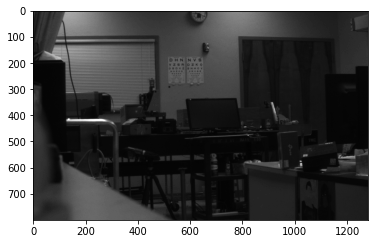

(800, 1280, 1)

In [3]:
path = '/groups/djbrady/Qian/real-test/2x2spectralarray-patch'
scene = 'scene2'
img0 = Image.open(f'{path}/{scene}/cam4_expo150.png')
img1 = Image.open(f'{path}/{scene}/cam1_expo500.png')
img2 = Image.open(f'{path}/{scene}/cam2_expo300.png')
img3 = Image.open(f'{path}/{scene}/cam3_expo800.png')
img0  = np.array(img0,  dtype=np.float32)[..., np.newaxis]
# img0 = (img0/img0.max())**(1/1.6)*255.0
img1 = np.array(img1, dtype=np.float32)[..., np.newaxis]
img2  = np.array(img2,  dtype=np.float32)[..., np.newaxis]
# img2 = img2*3./5.
img3 = np.array(img3, dtype=np.float32)[..., np.newaxis]
# img3 = img3*8./5. #, 0., 255.)
img_rights = [img1, img2, img3]
plt.imshow(img3, cmap='gray')
plt.show()
img0.shape

In [4]:
def toTensor(img):
    img = torch.from_numpy(img.transpose((2, 0, 1)))
    return img.float().div(255)

x_left = toTensor(img0).unsqueeze(0).to('cuda')
x_rights = [toTensor(img_right).unsqueeze(0).to('cuda') for img_right in img_rights]

In [5]:
net = PASSRnet(1, in_channel=1, num_input=4).to('cuda')
net = nn.DataParallel(net)
net.eval()
cudnn.benchmark = True
pretrained_dict = torch.load('log/x4/best.pth.tar')
net.load_state_dict(pretrained_dict['state_dict'])

<All keys matched successfully>

In [6]:
# res_w1, res_h1 = 1456, 1088
# res_w2, res_h2 = 1280, 800
# F1 = np.array([[4.07015327825553e-08,	4.17561843453929e-07,	-0.00808725180313401],
# [-1.95715470638663e-07,	6.97119492853064e-08,	-0.0317664092598450],
# [0.00536427411067715,	0.0236442325009365,	1.59796926454643]])
# F2 = np.array([[4.84985763781936e-08,	-3.22308340577842e-07,	-0.00715097517336016],
# [4.46350737251892e-07,	4.77193410572063e-08,	-0.0188197924505962],
# [0.00500787791406712,	0.0141203268780633,	0.658266562896339]])
# F3 = np.array([[1.66712445457951e-07,	-2.52883591320674e-07,	-0.0206496197252677],
# [5.66035189455234e-07,	1.10559973826720e-07,	-0.0320562113764354],
# [0.0147028462393742,	0.0241689869067774,	3.58052752388209]])
# image_coor = np.meshgrid(np.arange(res_h1), np.arange(res_w1))
# cam_coor = np.stack([image_coor[1].T,
#                      image_coor[0].T,
#                      np.ones_like(image_coor[1].T)], axis=2)
# image_coor2 = np.meshgrid(np.arange(res_h2), np.arange(res_w2))
# cam_coor2 = np.stack([image_coor2[1].T,
#                       image_coor2[0].T,
#                       np.ones_like(image_coor2[1].T)], axis=2)

In [7]:
with torch.no_grad():
    x_left = net.module.init_feature(x_left)
    x_rights = [net.module.init_feature(x_right) for x_right in x_rights]
    buffer_left = net.module.pam.rb(x_left)
    buffer_rights = [net.module.pam.rb(x_right) for x_right in x_rights]
    Q = net.module.pam.b1(buffer_left)
    Ss, Rs = [], []
    for i in range(len(buffer_rights)):
        Ss.append(net.module.pam.b2s[i](buffer_rights[i]))
        Rs.append(net.module.pam.b3s[i](buffer_rights[i]))

In [8]:
# with torch.no_grad():
#     fused_feature = torch.zeros((1, 256, 1088, 1456)).float().to('cuda')
#     for point_x in range(res_h1):
#         if point_x % 50 == 0:
#             print("point_x:", point_x)
#         for point_y in range(res_w1):
#             Q_ = Q[:, :, point_x:point_x+1,point_y:point_y+1]
#             Pos = []

#             lam = F1.dot(np.array([point_y, point_x, 1]).reshape((-1, 3)).T)
#             if (0.728*point_x - 50) < 0:
#                 x_lb, x_ub = 0, 100
#             elif (0.728*point_x + 50) > res_w2:
#                 x_lb, x_ub = res_w2 - 100, res_w2
#             else:
#                 x_lb, x_ub = int(.728*point_x - 50), int(.728*point_x + 50)
#             y_ub = min(int(.738*point_y + 228), res_w2)
#             y_lb = y_ub - 100
#             dist = np.abs(cam_coor2[x_lb:x_ub, y_lb:y_ub].reshape((-1, 3)).dot(lam))
#             n = 100
#             pps = np.argpartition(dist, n, axis=0)[:n].T
#             xxs, yys = pps//n + x_lb, pps%n+y_lb
#             Pos.append((torch.from_numpy(xxs), torch.from_numpy(yys)))

#             lam = F2.dot(np.array([point_y, point_x, 1]).reshape((-1, 3)).T)
#             if (0.728*point_x - 71) < 0:
#                 x_lb, x_ub = 0, 100
#             elif (0.728*point_x + 29) > res_w2:
#                 x_lb, x_ub = res_w2 - 100, res_w2
#             else:
#                 x_lb, x_ub = int(.728*point_x - 71), int(.728*point_x + 29)
#             y_ub = min(int(.738*point_y + 205), res_w2)
#             y_lb = y_ub - 100
#             dist = np.abs(cam_coor2[x_lb:x_ub, y_lb:y_ub].reshape((-1, 3)).dot(lam))
#             n = 100
#             pps = np.argpartition(dist, n, axis=0)[:n].T
#             xxs, yys = pps//n + x_lb, pps%n+y_lb
#             Pos.append((torch.from_numpy(xxs), torch.from_numpy(yys)))

#             lam = F3.dot(np.array([point_y, point_x, 1]).reshape((-1, 3)).T)
#             if (0.728*point_x - 60) < 0:
#                 x_lb, x_ub = 0, 100
#             elif (0.728*point_x + 40) > res_w2:
#                 x_lb, x_ub = res_w2 - 100, res_w2
#             else:
#                 x_lb, x_ub = int(.728*point_x - 60), int(.728*point_x + 40)
#             y_ub = min(int(.738*point_y + 236), res_w2)
#             y_lb = y_ub - 100
#             dist = np.abs(cam_coor2[x_lb:x_ub, y_lb:y_ub].reshape((-1, 3)).dot(lam))
#             n = 100
#             pps = np.argpartition(dist, n, axis=0)[:n].T
#             xxs, yys = pps//n + x_lb, pps%n+y_lb
#             Pos.append((torch.from_numpy(xxs), torch.from_numpy(yys)))

#             buffers = []
#             for S, R, Po in zip(Ss, Rs, Pos):
#                 buffer, _ = net.module.pam.fe_pam(Q_, S, R, Po, False)
#                 buffers.append(buffer)
#             buffers.append(x_left[:,:,point_x:point_x+1,point_y:point_y+1])
#             fused_feature[:,:,point_x:point_x+1,point_y:point_y+1] = torch.cat(tuple(buffers), 1)
#     out = net.module.pam.fusion(fused_feature)
#     out = net.module.upscale(out)

In [9]:
with torch.no_grad():
    fused_feature = torch.zeros((1, 256, 800, 1280)).float().to('cuda')
    for i in range(2):
        for j in range(2):
            
            ID = i*2+j+1
            print(ID)
            xl, xu, yl, yu = i*400, i*400+400, j*640, j*640+640
            
            Q_ = Q[:, :, xl:xu,yl:yu].contiguous()
            Pos = []

            for k in range(3):
                xxs = np.load('{}/xxs_{:04d}_{}.npy'.format(path, ID, k+1))[np.newaxis]
                yys = np.load('{}/yys_{:04d}_{}.npy'.format(path, ID, k+1))[np.newaxis]
                Pos.append((torch.from_numpy(xxs), torch.from_numpy(yys)))

            buffers = []
            for S, R, Po in zip(Ss, Rs, Pos):
#                 print(Q_.size(), S.size(), R.size(), Po[0].size())
                buffer, _ = net.module.pam.fe_pam(Q_, S, R, Po, False)
                buffers.append(buffer)
            buffers.append(x_left[:,:,xl:xu,yl:yu])
            fused_feature[:,:,xl:xu,yl:yu] = torch.cat(tuple(buffers), 1)
    out = net.module.pam.fusion(fused_feature)
    out = net.module.upscale(out)

1
2
3
4


In [10]:
with torch.no_grad():
    out = net.module.pam.fusion(fused_feature)
    out = net.module.upscale(out)

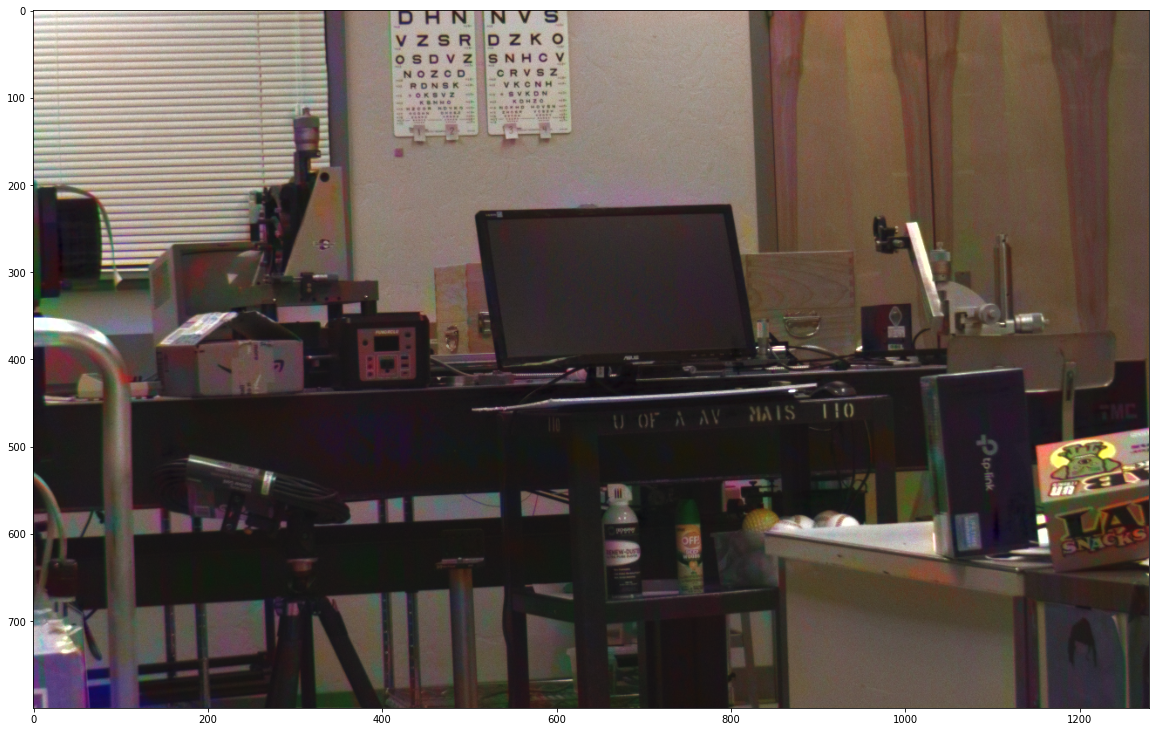

In [11]:
img = torch.clamp(out, 0, 1).squeeze().cpu().numpy().transpose(1, 2, 0)
plt.figure(figsize=(20,16))
plt.imshow(img)
plt.show()

<ipython-input-12-312149996168>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fI=inputImage.astype(np.float)


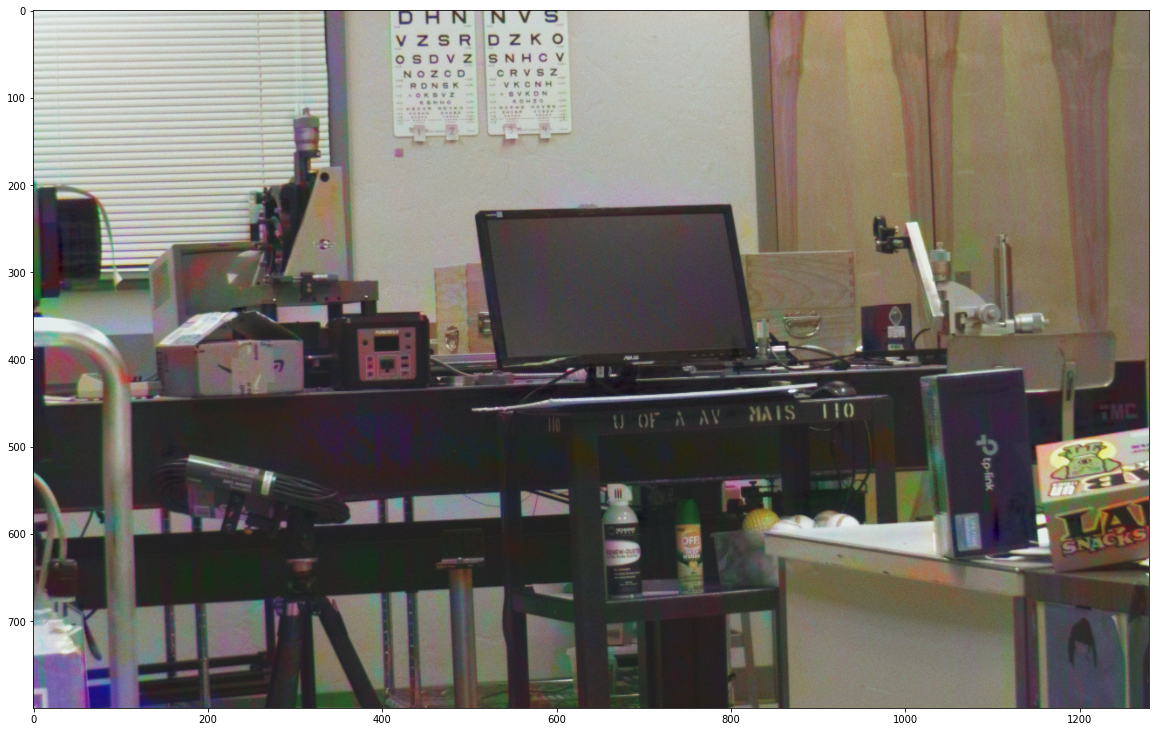

In [12]:
def adjustColor(inputImage,rc=1,bc=1,gc=1,gain=1,gamma = 0.5, contrast=1):
    fI=inputImage.astype(np.float)
    fI[:,:,0]=rc*fI[:,:,0]
    fI[:,:,1]=gc*fI[:,:,1]
    fI[:,:,2]=bc*fI[:,:,2]#
    fI=gain*fI/np.max(fI)
    fI = np.power(fI, 1/gamma)
    fI=255*np.tanh(contrast*fI)
    fI=fI.astype(np.uint8)
    return fI
img = adjustColor(img, rc = .9, bc = 1, gain = 1.1, gamma = 1, contrast = 1.5)
plt.figure(figsize=(20,16))
plt.imshow(img)
plt.show()

In [13]:
cv2.imwrite(f'results/2x2spectralarray-patch_{scene}_asawhole_x4.png', img[..., ::-1])

True